# Aligning two views through stereo rectification

In this recipe, you will learn how to rectify two images captured using a stereo camera with known parameters in such a way that, for the point $(xl, yl)$ in the left image, the corresponding epipolar line in the right image is $yr=yl$ and vice versa. This greatly simplifies feature matching and dense stereo estimation algorithms.

We load stereo rig parameters estimated earlier from file. The rectification procedure itself estimates such camera transformations so that two separate image planes become the same plane afterwards. This greatly simplifies the epipolar geometry constraints and makes the job for all other stereo-related algorithms much easier.

The rectification transformation parameters are estimated using the `cv2.stereoRectify` function—it takes the stereo rig parameters and returns the rectification parameters: the first camera rotation, second camera rotation, first camera projection matrix, second camera projection matrix, disparity-to-depth mapping matrix, the first camera ROI where all the pixels are valid, and the second camera ROI where all the pixels are valid.

We only use the first two parameters; the first and second camera rotations are used to construct rectification transformation per-pixel maps using the `cv2.initUndistortRectifyMap` function. When the map has been computed once, it can then be used for any images captured using the stereo rig.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    #plt.gca().invert_yaxis() plt.gca().invert_xaxis()
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S09\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s09\env

d:\html_doc\program\opencv\packt\s09\env\lib\site-packages
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\pip-20.1-py3.8.egg
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S09\env


In [2]:
data = np.load('data/stereo/case1/stereo.npy',allow_pickle = True).item()
Kl, Dl, Kr = data['Kl'], data['Dl'], data['Kr']
Dr, R, T, img_size = data['Dr'], data['R'], data['T'], data['img_size']

In [3]:
left_img = cv2.imread('data/stereo/case1/left14.png')
right_img = cv2.imread('data/stereo/case1/right14.png')

In [4]:
R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(Kl, Dl, Kr, Dr, img_size, R, T)

In [5]:
xmap1, ymap1 = cv2.initUndistortRectifyMap(Kl, Dl, R1, P1, img_size, cv2.CV_32FC1)
xmap2, ymap2 = cv2.initUndistortRectifyMap(Kr, Dr, R2, P2, img_size, cv2.CV_32FC1)

In [6]:
left_img_rectified = cv2.remap(left_img, xmap1, ymap1, cv2.INTER_LINEAR)
right_img_rectified = cv2.remap(right_img, xmap2, ymap2, cv2.INTER_LINEAR)

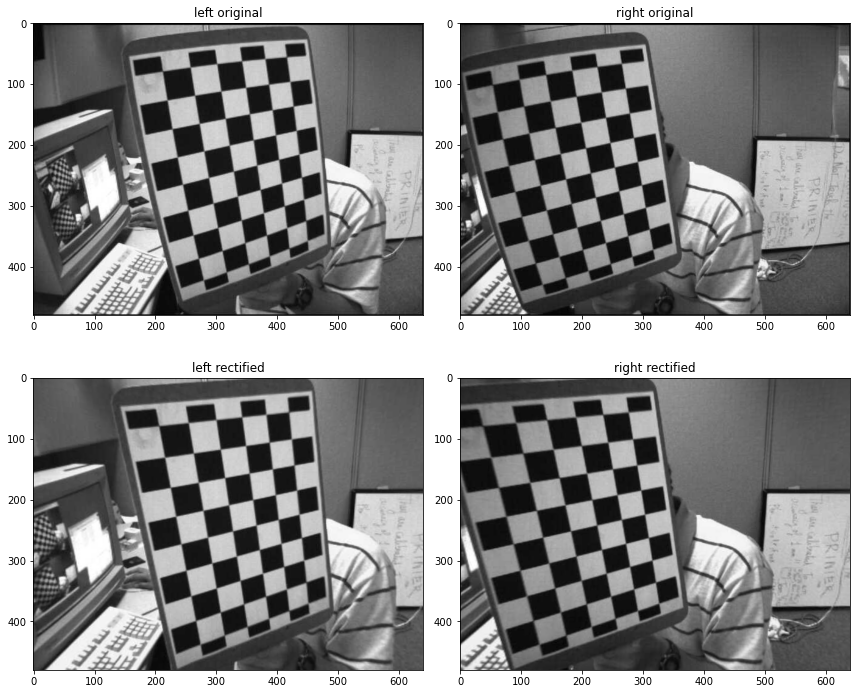

In [7]:
plt.figure(0, figsize=(12,10))
plt.subplot(221)
plt.title('left original')
plt.imshow(left_img, cmap='gray')
plt.subplot(222)
plt.title('right original')
plt.imshow(right_img, cmap='gray')
plt.subplot(223)
plt.title('left rectified')
plt.imshow(left_img_rectified, cmap='gray')
plt.subplot(224)
plt.title('right rectified')
plt.imshow(right_img_rectified, cmap='gray')
plt.tight_layout()
plt.show()